In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from scipy.stats import shapiro, probplot, mannwhitneyu

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

Пути к директориям и файлам

In [2]:
TRAIN_DATASET_PATH = r'C:\Users\aermo\Credit Default\train.csv'
TEST_DATASET_PATH = r'C:\Users\aermo\Credit Default\test.csv'

Вспомогательные функции

In [3]:
def show_distplot(feature, data, title, figsize):
    """Диаграмма распределения признака со средней, медианой и модой"""
    
    target_mean = round(data[feature].mean(), 2)
    target_median = data[feature].median()
    target_mode = data[feature].mode()[0]

    plt.figure(figsize = figsize)

    sns.distplot(data[feature], bins=70)

    plt.axvline(x=[target_mean], label='target_mean', linestyle=':',linewidth=4, color='red')
    plt.axvline(x=[target_median], label='target_median', linestyle='--', linewidth=4, color='green')
    plt.axvline(x=[target_mode], label='target_mode', linestyle='-.', linewidth=4, color='orange')
    plt.title(title)
    plt.legend()

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """Отчет с метриками модели"""
    
    print('Train\n\n' + classification_report(y_train_true, y_train_pred))
    print('Test\n\n' + classification_report(y_test_true, y_test_pred))
    print('Confusion Matrix\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [5]:
def evaluate_preds(model, y_train, y_test, train_pool, test_pool):
    """Валидация модели, вывод отчетов"""
    
    y_train_pred = model.predict(train_pool)
    y_test_pred = model.predict(test_pool)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Загрузка данных

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [7]:
train_df.tail(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0
7499,Rent,NaN,4 years,0.0,8.0,9.4,480832.0,0.0,NaN,0.0,debt consolidation,Short Term,26928.0,288192.0,9061.0,NaN,0


Home Ownership - домовладение\
Annual Income - годовой доход\
Years in current job - количество лет на текущем месте работы\
Tax Liens - налоговые обременения\
Number of Open Accounts - количество открытых счетов\
Years of Credit History - количество лет кредитной истории\
Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)\
Number of Credit Problems - количество проблем с кредитом\
Months since last delinquent - количество месяцев с последней просрочки платежа\
Bankruptcies - банкротства\
Purpose - цель кредита\
Term - срок кредита\
Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)\
Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)\
Monthly Debt - ежемесячный долг\
Credit Score - баллы кредитного рейтинга\
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

# EDA

Целевая переменная

In [9]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Числовые признаки

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

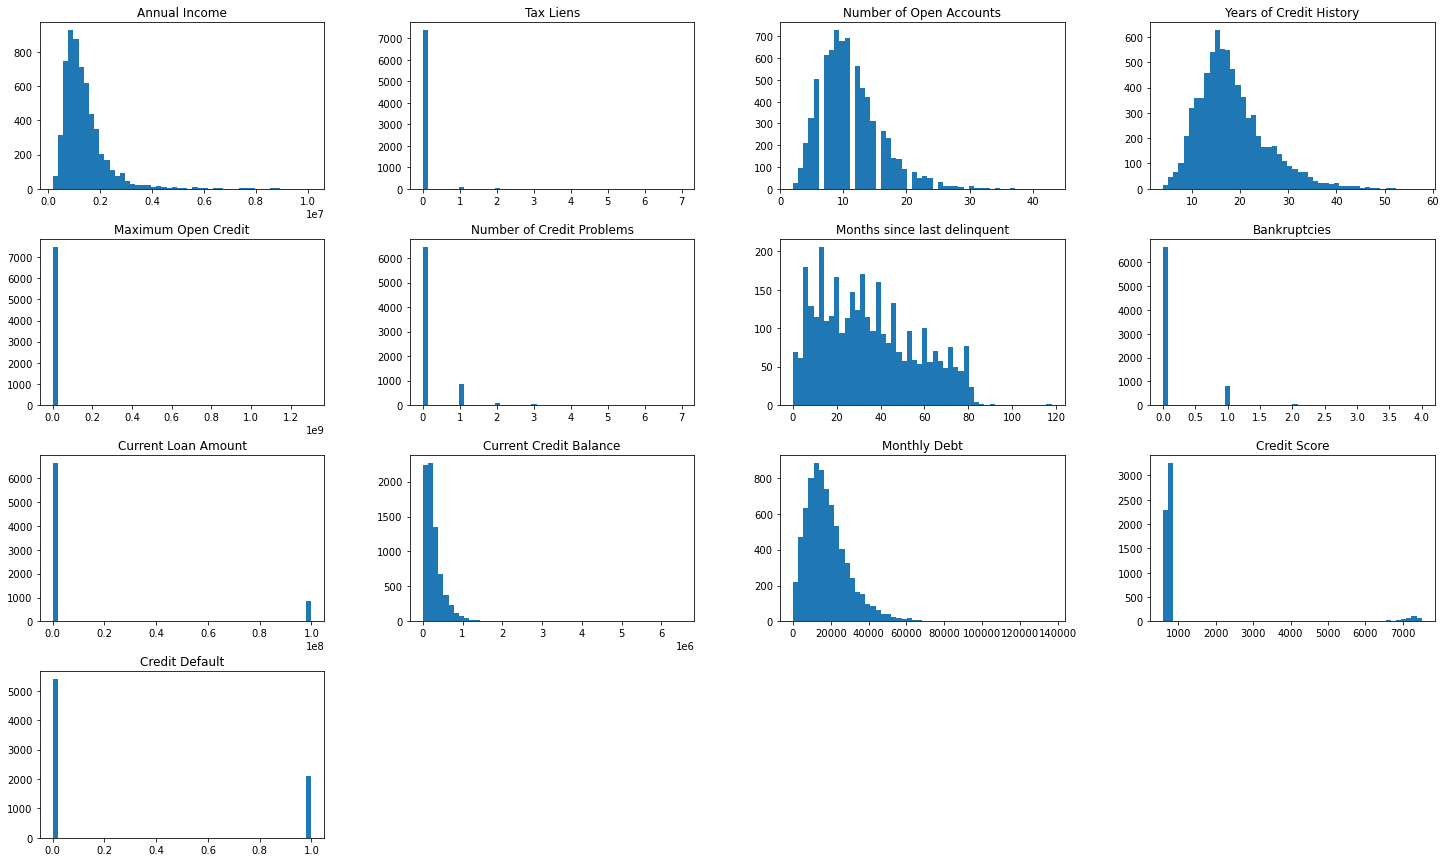

In [10]:
train_df.select_dtypes(exclude=['object']).hist(figsize=(25,15), bins=50, grid=False)

С выбросами пока ничего делать не будем

Создадим класс для обработки данных

In [11]:
class DataPreprocessing:

    def __init__(self):
        
        self.medians = None
        self.model_regr_CrSc = None
        self.model_regr_AnIn = None
        
    def fit(self, df):
        
        self.medians = df[['Annual Income', 'Credit Score']].median()
    
    def fit_regr_Credit_Score(self, df):
        """Создание регрессии по Credit Score, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Credit_Score_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Credit_Score_isnan'], axis=1)
        target_name_regr = 'Credit Score'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_CrSc = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=4,
            iterations=400,
            learning_rate=0.03,
            l2_leaf_reg=2
        )

        self.model_regr_CrSc.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )

        print(f'Credit Score R2: {self.model_regr_CrSc.get_best_score()}')
        del df_regr
        
    def fit_regr_Annual_Income(self, df):
        """Создание регрессии по Annual Income, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Annual_Income_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Annual_Income_isnan'], axis=1)
        target_name_regr = 'Annual Income'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_AnIn = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=6,
            iterations=900,
            learning_rate=0.5,
            l2_leaf_reg=3.5
        )

        self.model_regr_AnIn.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )
        
        print(f'Annual Income R2: {self.model_regr_AnIn.get_best_score()}')
        del df_regr
    
    def apply_regr_Credit_Score(self, df):
        """Заполнение пропусков Credit Score"""
        
        cond = (df['Credit_Score_isnan'] == 1)
        Xc = df[cond].drop(['Credit Score', 'Credit Default', 'Credit_Score_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Credit Score'] = self.model_regr_CrSc.predict(Xc)
        df = df.drop(['Credit_Score_isnan', 'Credit_Score_cat'], axis=1)
        return df

    def apply_regr_Annual_Income(self, df):
        """Заполнение пропусков Annual Income"""
        
        cond = (df['Annual_Income_isnan'] == 1)
        Xc = df[cond].drop(['Annual Income', 'Credit Default', 'Annual_Income_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Annual Income'] = self.model_regr_AnIn.predict(Xc)
        df = df.drop(['Annual_Income_isnan', 'Annual_Income_cat'], axis=1)
        return df
    
    def transform(self, df):
        
        # пропуски
        df['Years in current job'].fillna('nan', inplace=True)
        df['Months since last delinquent'].fillna(0, inplace=True)
        df['Bankruptcies'].fillna(0, inplace=True)
        
        # заполнение Annual Income регрессией
        df['Annual_Income_isnan'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual_Income_isnan'] = 1
        df['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        
        # заполнение Credit Score регрессией
        df['Credit_Score_isnan'] = 0
        df.loc[df['Credit Score'].isna(), 'Credit_Score_isnan'] = 1
        df['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        return df
    
    def features(self, df):
        
        # признак с кредитным рейтингом
        # используется при регрессии, далее удаляется
        df = self.credit_score_to_cat(df)
        
        # признак с текущей суммой кредита, разбитой на категории
        df = self.current_loan_amount_to_cat(df)
        
        # признак с годовым доходом, разбитым на категории
        # используется при регрессии, далее удаляется
        df = self.annual_income_to_cat(df)
        
        columns_to_int = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']
        df[columns_to_int] = df[columns_to_int].astype(int)
        
        return df
    
    @staticmethod
    def credit_score_to_cat(df):
        """Создание признака Credit_Score_cat"""
        
        df['Credit_Score_cat'] = np.nan
        
        df.loc[df['Credit Score'] < 600, 'Credit_Score_cat'] = 1
        df.loc[(df['Credit Score'] >= 600) & (df['Credit Score'] < 650), 'Credit_Score_cat'] = 2
        df.loc[(df['Credit Score'] >= 650) & (df['Credit Score'] < 700), 'Credit_Score_cat'] = 3
        df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 725), 'Credit_Score_cat'] = 4
        df.loc[(df['Credit Score'] >= 725) & (df['Credit Score'] < 735), 'Credit_Score_cat'] = 5
        df.loc[(df['Credit Score'] >= 735) & (df['Credit Score'] < 745), 'Credit_Score_cat'] = 6
        df.loc[(df['Credit Score'] >= 745) & (df['Credit Score'] < 755), 'Credit_Score_cat'] = 7
        df.loc[df['Credit Score'] >= 755, 'Credit_Score_cat'] = 8
        
        df['Credit_Score_cat'] = df['Credit_Score_cat'].astype(int)
        
        return df
    
    @staticmethod
    def current_loan_amount_to_cat(df):
        """Создание признака Current_Loan_Amount_cat"""
        
        df['Current_Loan_Amount_cat'] = np.nan
        
        df.loc[df['Current Loan Amount'] < 100000, 'Current_Loan_Amount_cat'] = 1
        df.loc[(df['Current Loan Amount'] >= 100000) & (df['Current Loan Amount'] < 150000), 'Current_Loan_Amount_cat'] = 2
        df.loc[(df['Current Loan Amount'] >= 150000) & (df['Current Loan Amount'] < 250000), 'Current_Loan_Amount_cat'] = 3
        df.loc[(df['Current Loan Amount'] >= 250000) & (df['Current Loan Amount'] < 300000), 'Current_Loan_Amount_cat'] = 4
        df.loc[(df['Current Loan Amount'] >= 300000) & (df['Current Loan Amount'] < 325000), 'Current_Loan_Amount_cat'] = 5
        df.loc[(df['Current Loan Amount'] >= 325000) & (df['Current Loan Amount'] < 350000), 'Current_Loan_Amount_cat'] = 6
        df.loc[(df['Current Loan Amount'] >= 350000) & (df['Current Loan Amount'] < 400000), 'Current_Loan_Amount_cat'] = 7
        df.loc[(df['Current Loan Amount'] >= 400000) & (df['Current Loan Amount'] < 450000), 'Current_Loan_Amount_cat'] = 8
        df.loc[(df['Current Loan Amount'] >= 450000) & (df['Current Loan Amount'] < 500000), 'Current_Loan_Amount_cat'] = 9
        df.loc[df['Current Loan Amount'] >= 500000, 'Current_Loan_Amount_cat'] = 10
        
        df['Current_Loan_Amount_cat'] = df['Current_Loan_Amount_cat'].astype(int)
        
        return df

    @staticmethod
    def annual_income_to_cat(df):
        """Создание признака Annual_Income_cat"""
        
        df['Annual_Income_cat'] = np.nan
        
        df.loc[df['Annual Income'] < 500000, 'Annual_Income_cat'] = 1
        df.loc[(df['Annual Income'] >= 500000) & (df['Annual Income'] < 750000), 'Annual_Income_cat'] = 2
        df.loc[(df['Annual Income'] >= 750000) & (df['Annual Income'] < 1000000), 'Annual_Income_cat'] = 3
        df.loc[(df['Annual Income'] >= 1000000) & (df['Annual Income'] < 1125000), 'Annual_Income_cat'] = 4
        df.loc[(df['Annual Income'] >= 1125000) & (df['Annual Income'] < 1250000), 'Annual_Income_cat'] = 5
        df.loc[(df['Annual Income'] >= 1250000) & (df['Annual Income'] < 1500000), 'Annual_Income_cat'] = 6
        df.loc[(df['Annual Income'] >= 1500000) & (df['Annual Income'] < 1750000), 'Annual_Income_cat'] = 7
        df.loc[(df['Annual Income'] >= 1750000) & (df['Annual Income'] < 2000000), 'Annual_Income_cat'] = 8
        df.loc[(df['Annual Income'] >= 2000000) & (df['Annual Income'] < 2500000), 'Annual_Income_cat'] = 9
        df.loc[df['Annual Income'] >= 2500000, 'Annual_Income_cat'] = 10
        
        df['Annual_Income_cat'] = df['Annual_Income_cat'].astype(int)
        
        return df
    

Инициализация класса

In [12]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

data_inst = DataPreprocessing()

# тренировочный датасет
data_inst.fit(train_df)
df_train = data_inst.transform(train_df)
df_train = data_inst.features(df_train)

# регрессия Credit Score
data_inst.fit_regr_Credit_Score(df_train)
df_train = data_inst.apply_regr_Credit_Score(df_train)

# регрессия Annual Income
data_inst.fit_regr_Annual_Income(df_train)
df_train = data_inst.apply_regr_Annual_Income(df_train)

# тестовый датасет
df_valid = data_inst.transform(test_df)
df_valid = data_inst.features(df_valid)
df_valid = data_inst.apply_regr_Credit_Score(df_valid)
df_valid = data_inst.apply_regr_Annual_Income(df_valid)

target_name = 'Credit Default'
feature_names = df_train.columns.drop(target_name).tolist()
feature_names_num = df_train.select_dtypes(include='float64').columns.tolist()
feature_names_cat = df_train.select_dtypes(include=['int64', 'object']).columns.drop(target_name).tolist()

Credit Score R2: {'learn': {'R2': 0.9983528978838869, 'RMSE': 66.63580824879395}, 'validation': {'R2': 0.9978774841863697, 'RMSE': 69.65118334346334}}
Annual Income R2: {'learn': {'R2': 0.9394196878360358, 'RMSE': 204333.80300749763}, 'validation': {'R2': 0.8267486439209119, 'RMSE': 366050.60106834694}}


# Корреляция признаков

Text(0.5, 1.0, 'Correlation with target variable')

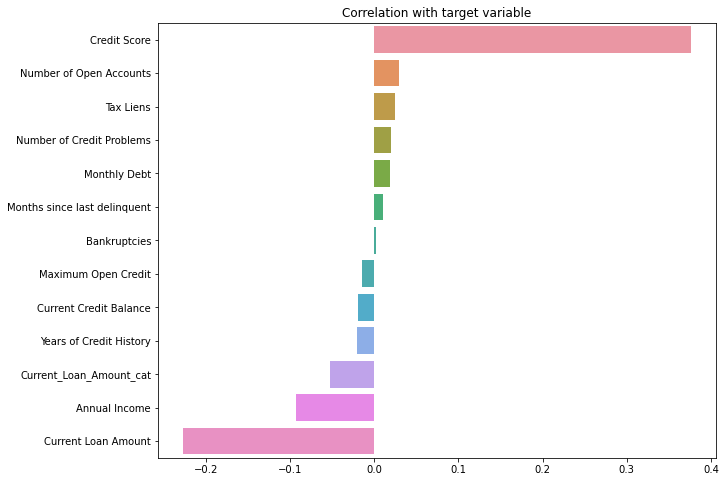

In [13]:
corr_with_target = df_train[feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')

# Матрица корреляций

Text(0.5, 1.0, 'Correlation matrix')

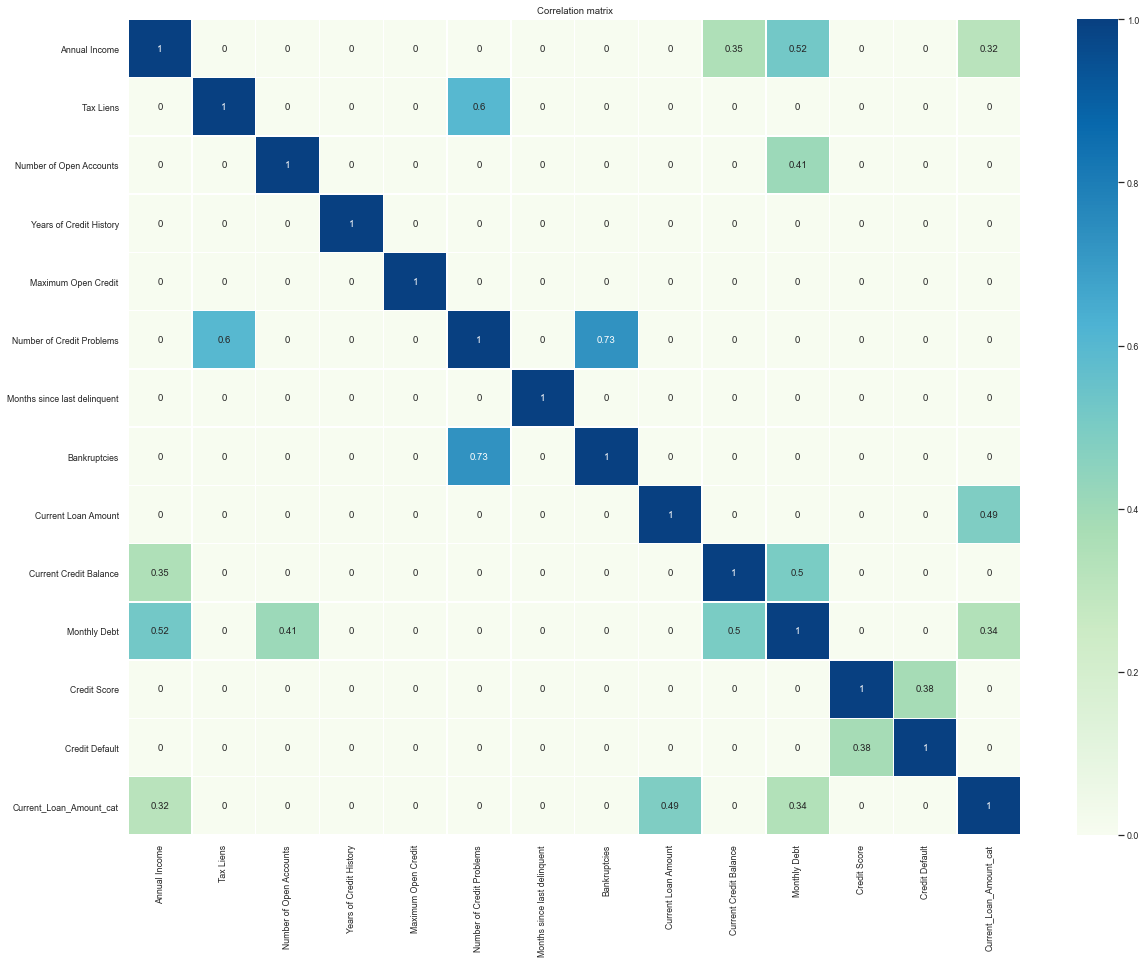

In [14]:
plt.figure(figsize = (20,15))

sns.set(font_scale=0.8)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')

# Разбиение обучающего датасета на train и test

In [15]:
X = df_train[feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=True,
    test_size=0.3,
    random_state=42,
    stratify=y
)

## Проверка распределения вещественных признаков на X_train и X_test

Annual Income: 0.064
Number of Open Accounts: 0.303
Years of Credit History: 0.379
Maximum Open Credit: 0.452
Months since last delinquent: 0.311
Current Loan Amount: 0.119
Current Credit Balance: 0.382
Monthly Debt: 0.05
Credit Score: 0.263


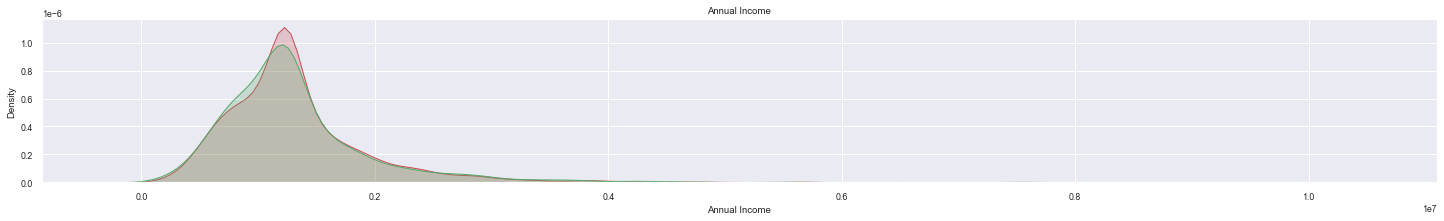

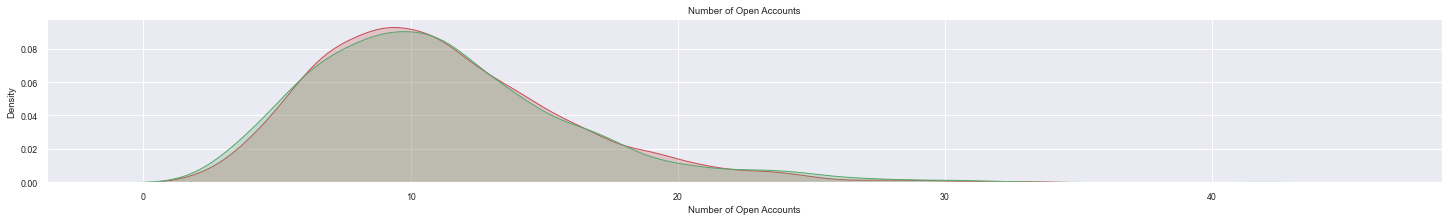

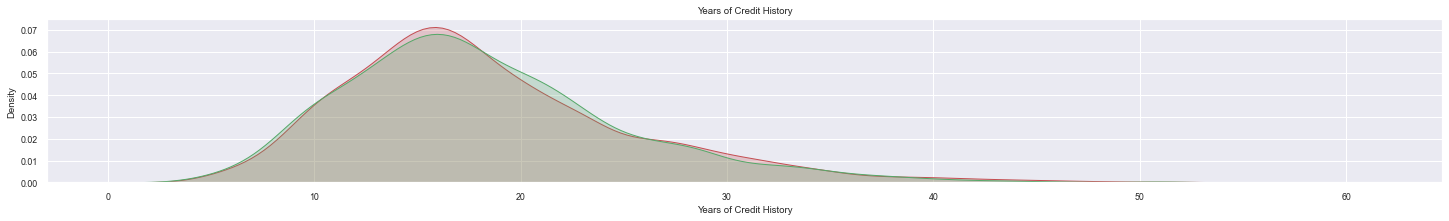

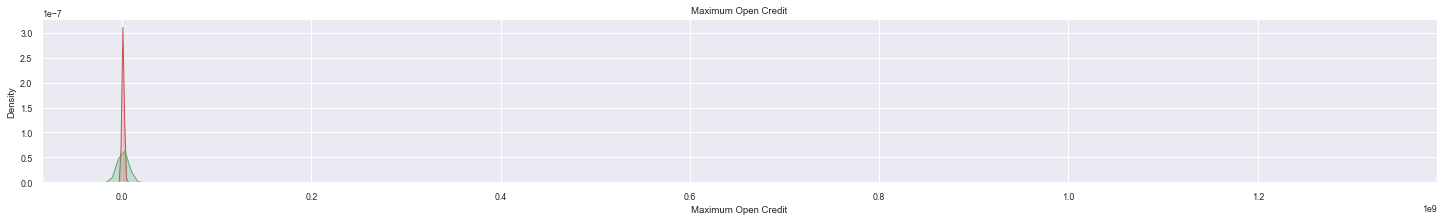

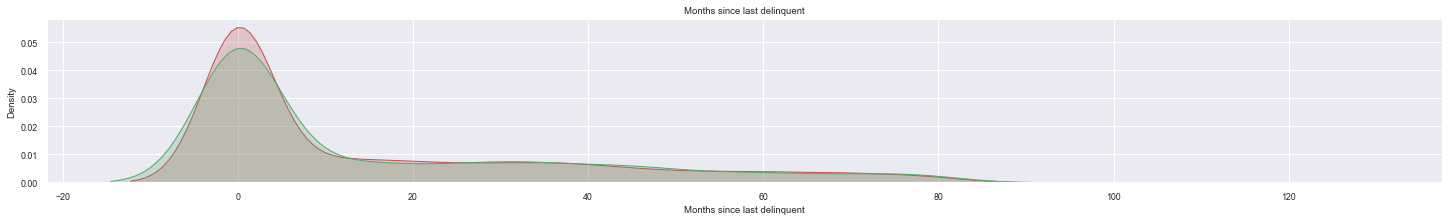

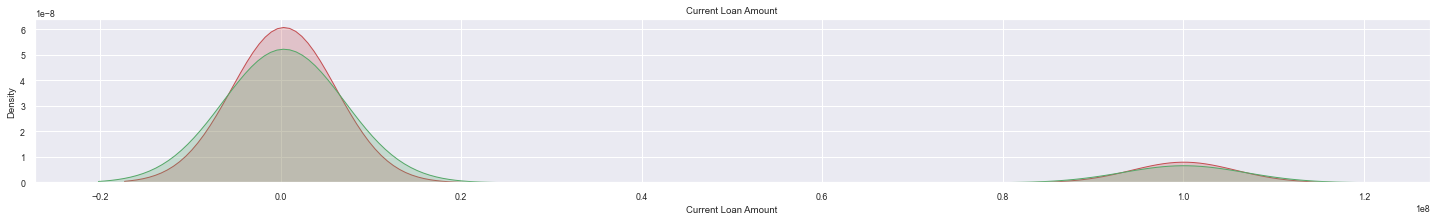

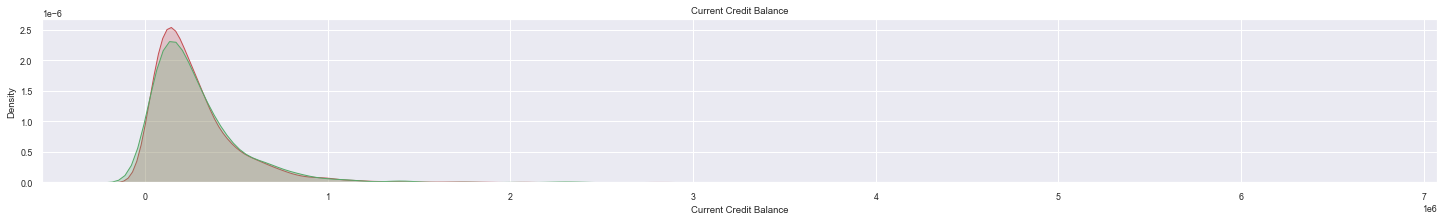

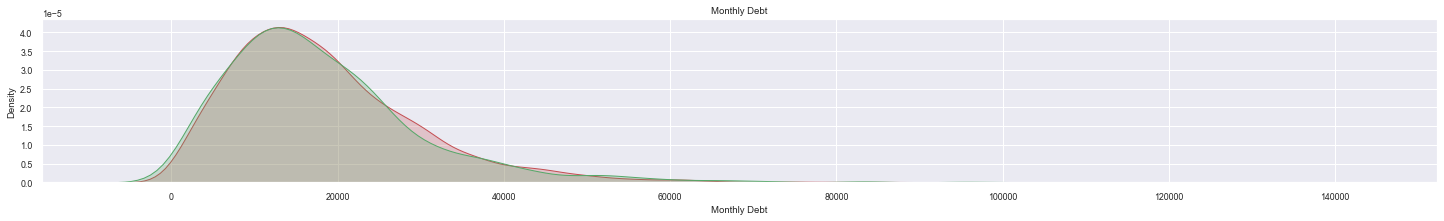

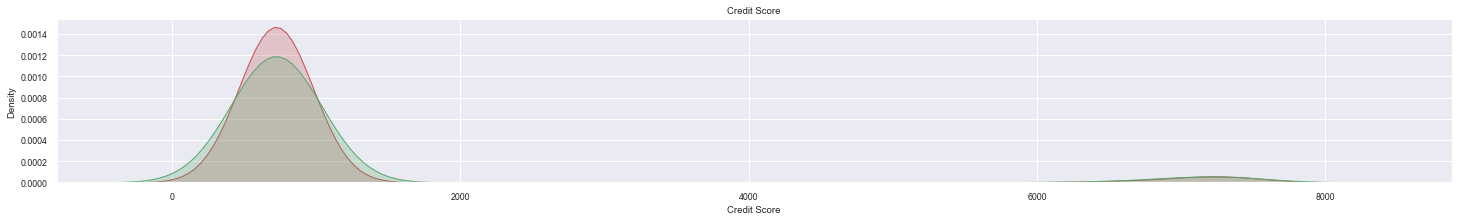

In [16]:
for col in feature_names_num:
    print(col + ': ' + str(round(mannwhitneyu(X_train[col], X_test[col])[1], 3)))
    plt.figure(figsize=(25, 3))
    sns.set(font_scale=0.8)
    sns.kdeplot(X_train[col], shade=True, label='train', color='r')
    sns.kdeplot(X_test[col], shade=True, label='test', color='g')
    plt.title(col)

## Проверка распределения категориальных признаков на X_train и X_test

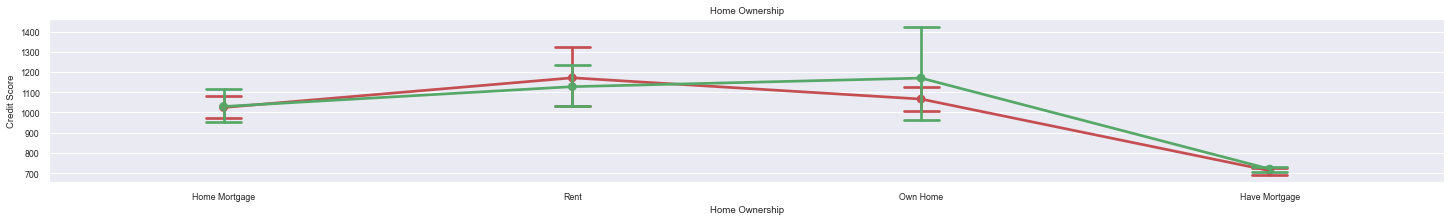

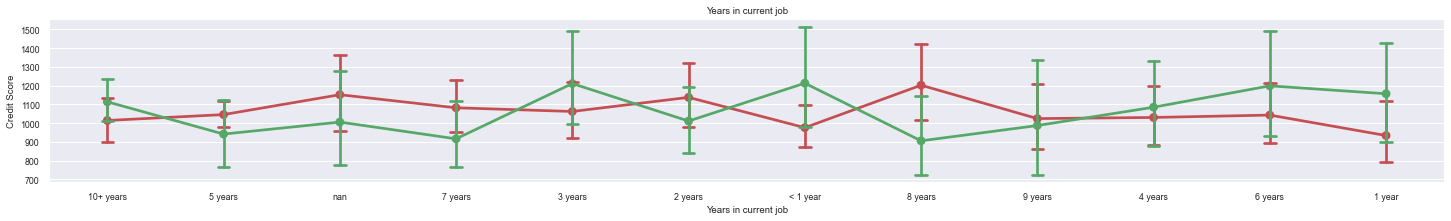

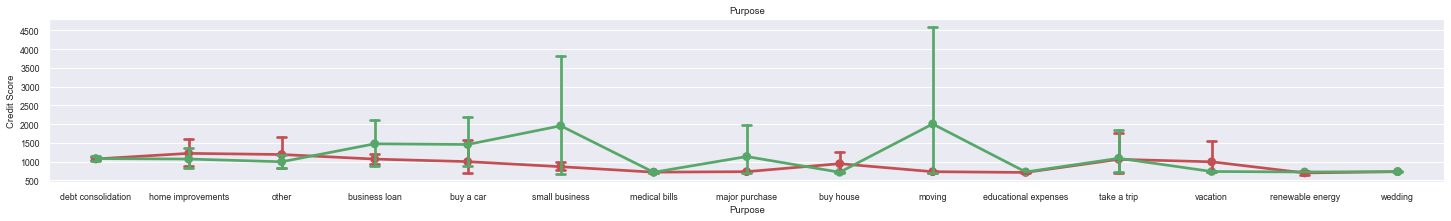

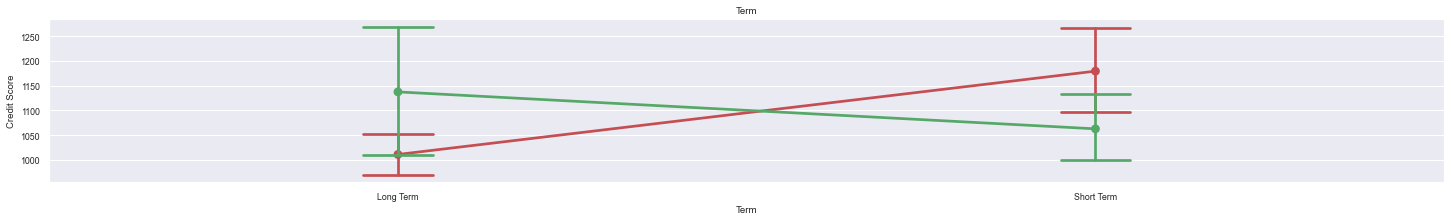

In [17]:
num_feature = 'Credit Score'
for col in feature_names_cat:
    plt.figure(figsize=(25, 3))
    sns.pointplot(x=col, y=num_feature, data=X_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=X_test, capsize=.1, label='test', color='g')
    plt.title(col)

# Обучение модели

Определение максимального количества уникальных значений среди категориальных признаков

In [18]:
sorted([X_train[feature_names_cat][col].nunique() for col in feature_names_cat])[-1]

15

Определение гиперпараметров

In [19]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=feature_names_cat
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=feature_names_cat
) 

params_model = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

In [20]:
%%time

cbr_model = CatBoostClassifier(**params_model)

params_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2]
}

gs = cbr_model.randomized_search(
    params_grid,
    train_pool,
    n_iter=20,
    shuffle=True,
    stratified=True,
    partition_random_seed=42,
    cv=5
)

gs

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6712235526
bestIteration = 2

0:	loss: 0.6712236	best: 0.6712236 (0)	total: 993ms	remaining: 18.9s

bestTest = 0.6729703121
bestIteration = 91

1:	loss: 0.6729703	best: 0.6729703 (1)	total: 6.51s	remaining: 58.6s

bestTest = 0.6672013012
bestIteration = 78

2:	loss: 0.6672013	best: 0.6729703 (1)	total: 11.4s	remaining: 1m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7000355266
bestIteration = 25

3:	loss: 0.7000355	best: 0.7000355 (3)	total: 15.7s	remaining: 1m 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6935617577
bestIteration = 13

4:	loss: 0.6935618	best: 0.7000355 (3)	total: 18.7s	remaining: 56.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6900483825
bestIteration = 28

5:	loss: 0.6900484	best: 0.7000355 (3)	total: 27s	remaining: 1m 3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7086321973
bestIteration = 110

6:	

{'params': {'depth': 4,
  'iterations': 400,
  'bagging_temperature': 1.5,
  'learning_rate': 0.1,
  'l2_leaf_reg': 2.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
     

In [21]:
%%time

cbr_final_model = CatBoostClassifier(
    **params_model,
    depth=4,
    iterations=400,
    learning_rate=0.1,
    l2_leaf_reg=2.5,
    bagging_temperature=1.5
)

cbr_final_model.fit(train_pool, eval_set=test_pool)

Wall time: 1.14 s


In [22]:
evaluate_preds(cbr_final_model, y_train, y_test, train_pool, test_pool)

Train

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      3771
           1       0.51      0.67      0.58      1479

    accuracy                           0.72      5250
   macro avg       0.68      0.71      0.68      5250
weighted avg       0.75      0.72      0.73      5250

Test

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1616
           1       0.50      0.67      0.57       634

    accuracy                           0.72      2250
   macro avg       0.67      0.70      0.68      2250
weighted avg       0.75      0.72      0.73      2250

Confusion Matrix

col_0              0    1
Credit Default           
0               1191  425
1                211  423


Веса признаков

In [23]:
feature_importances = pd.DataFrame(
    zip(X.columns, cbr_final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
15,Credit Score,54.465545
12,Current Loan Amount,34.103086
11,Term,3.387950
1,Annual Income,2.646357
6,Maximum Open Credit,1.015392
14,Monthly Debt,0.745003
4,Number of Open Accounts,0.500934
0,Home Ownership,0.486203
2,Years in current job,0.427889
13,Current Credit Balance,0.404909


# Прогнозирование на тестовом датасете¶

In [24]:
test_df.shape

(2500, 21)

In [25]:
submit = pd.read_csv(r'C:\Users\aermo\downloads\sample_submission.csv')
submit.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [26]:
predictions = cbr_final_model.predict(df_valid)
predictions

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [27]:
preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'Id': np.arange(0,predictions.shape[0]), 'Credit Default': predictions})
preds_final.to_csv('Credit_Default_CBR.csv', index=False, encoding='utf-8', sep=',')
preds_final.head(10)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,0
7,7,1
8,8,0
9,9,0
